# Reconstructing Trajectories with BSplines

In [20]:
using TaD, Plots

## Example: Helix in 3-D


In [53]:
function helix(;Ω1::Tuple=(0.,4*π), Ω2::Tuple=(0.,4*π), n::Int64=100, α::Tuple=(1.,1.,1.))
    """
    Constructs nx3 Matrix [α1cos.(θ) α2sin.(θ), α3LinRange(Ω, n+1)]
    """
    arr = zeros(Float64, (n+1, 3))
    arr[:, 1] = α[1]*cos.(LinRange(Ω1[1], Ω1[2], n+1))
    arr[:, 2] = α[2]*sin.(LinRange(Ω2[1], Ω2[2], n+1))
    arr[:, 3] = α[3]*LinRange(0, Ω1[2]-Ω1[1], n+1)
    arr
end

helix (generic function with 1 method)

In [74]:
λ = helix(n=1000) #Helix Derivative
Λ = helix(Ω1=(-π/2, 4*π-π/2), Ω2=(π/2, 4*π+π/2), n=1000, α=(1,-1,1)) # Original Helix
tup = asc(λ[:,3], λ, [0.0,-1.,0.])
Curve = reconstruct_trajectory(hcat(tup[1], tup[2], λ[:,3]))
plot(tuple(λ[:,1], λ[:,2], λ[:,3]), label="Helix Tangents")
plot!(tuple(Λ[:,1], Λ[:,2], Λ[:,3]), label="Original Helix")
plot!(Curve, label="ASC Reconstruct")

print("Error: ", norm(evaluate(Curve, length(λ[:,1])) - Λ))

Error: 0.0005956161828674758

## Example: Test data from Abughaban et al.

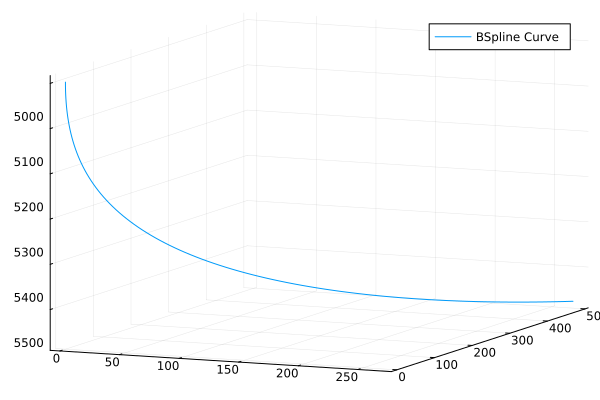

In [95]:
#Test data from Abughaban et al. https://onepetro.org/SPEDC/proceedings/16DC/3-16DC/Fort%20Worth,%20Texas,%20USA/207817
MD = collect(5000:100:5900)
θ, ϕ = to_radian(collect(0:5:45)), to_radian(collect(0:10:90))
λ = asc_tangents(MD, θ, ϕ)
tup = asc(MD, λ, [0., 0., 5000.])
Curve = reconstruct_trajectory(hcat(tup...))
N = [0.00 8.69 34.29 75.46 130.05 195.24 267.75 344.03 420.52 493.85]
plot(Curve, zaxis=(:flip))
#print(norm(evaluate(Curve, length(MD))[:,2] - N'))

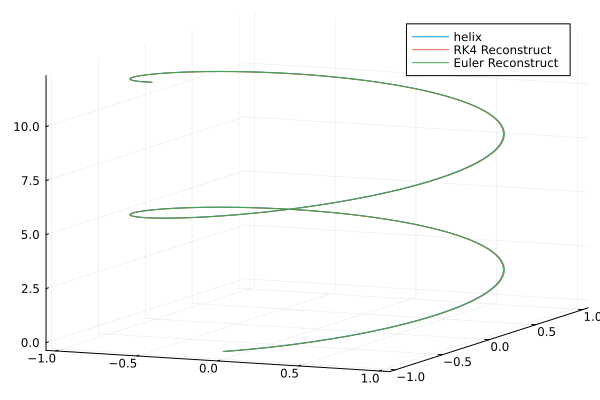

In [29]:
#Fundamentally, the ASC algorithm used to reconstruct a curve from its tangents is an euler method similar to RK4. 
# Here is the recreation of a helix in 3d using Rk4 and Euler Method: 
function rk4(∇f, x, δ)
    return (∇f.(x) + 4*∇f.(x.+δ/2) + ∇f.(x.+δ))*δ/6
end
function euler(∇f, x, δ)
    return (∇f.(x))*δ
end
f(x) = sin(x)
df(x) = cos(x)
g(x) = -cos(x)
dg(x) = sin(x)
rk4(df, 0:.1:12, .1)
plot((f.(0:.1:12), g.(0:.1:12), 0:.1:12), label="helix")
#plot!((df.(0:.1:12), dg.(0:.1:12), 0:.1:12), label="tangents")
plot!((cumsum(rk4(df, 0:.01:12, .01)), cumsum(rk4(dg, 0:.01:12, .01))  .- 1 , 0:.01:12), label="RK4 Reconstruct")
plot!((cumsum(euler(df, 0:.01:12, .01)), cumsum(euler(dg, 0:.01:12, .01))  .- 1 , 0:.01:12), label="Euler Reconstruct")

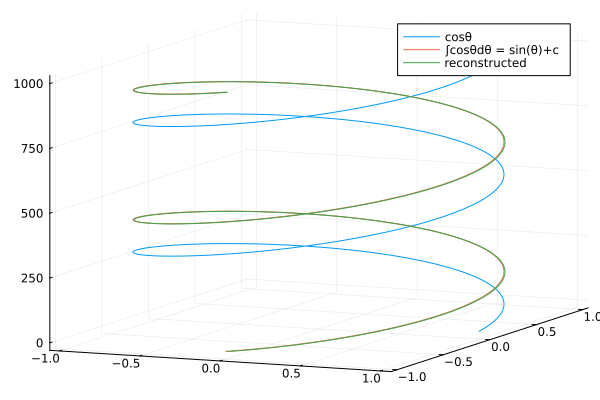

In [68]:
#Here is the same algorithm without using julia functions
λ = helix(n=1000)
Λ = helix(Ω1=(-π/2, 4*π-π/2), Ω2=(π/2, 4*π+π/2), n=1000, α=(1,-1,1)) # Original Helix
γ = hcat(map(x->cumsum(x .* (4*π/1000)), (λ[:,1], λ[:,2]))...)
plot(tuple(λ[:,1], λ[:,2], 1:1:length(λ[:,1])), label="cosθ")
plot!(tuple(Λ[:,1], Λ[:,2], 1:1:length(Λ[:,1])), label="ʃcosθdθ = sin(θ)+c")
plot!(tuple(γ[:,1], γ[:,2] .- 1, 1:1:length(γ[:,1])), label="reconstructed") #c = 1